In [2]:
import torch
import numpy as np
import pandas as pd
import PIL
import sklearn
import os
from sklearn.model_selection import train_test_split
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights
print(torch.cuda.is_available(),
torch.cuda.device_count(),
torch.cuda.current_device(),
torch.cuda.get_device_name(0))

True 1 0 NVIDIA GeForce GTX 1660


In [3]:
def configurate():
    global device, split_random_state, mask_path, image_path
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    print()

    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

    split_random_state = 30
    mask_path = 'C:/Users/Mihail/Desktop/Учёба/ML/data/dice/dice_photoset_2/masks/'
    image_path = 'C:/Users/Mihail/Desktop/Учёба/ML/data/dice/dice_photoset_2/changed/'
configurate()


Using device: cuda

NVIDIA GeForce GTX 1660
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
def load_samples():
    global X_filenames, y_dir
    path = '../../data/dice/dice_photoset_2/'
    X_filenames = pd.read_csv(path + 'filename.csv', index_col=0)
    y_dir = {'labels' : [], 'boxes' : []}
    directory = os.fsencode(path + 'labels/')
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        y_dir['labels'].append(torch.load(path + 'labels/' + filename))
    directory = os.fsencode(path + 'coordinates/')
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        y_dir['boxes'].append(torch.load(path + 'coordinates/' + filename))
    y_dir['labels'] = pd.Series(y_dir['labels'], index=X_filenames.index.copy())
    y_dir['boxes'] = pd.Series(y_dir['boxes'], index=X_filenames.index.copy())
load_samples()

In [5]:
X_train_filenames, X_test_filenames, y_boxes_train, y_boxes_test, y_labels_train, y_labels_test = train_test_split(X_filenames, y_dir['boxes'], y_dir['labels'], test_size=0.2, random_state=split_random_state, shuffle=True) # train_index, test_index

In [3]:
from torch import nn
class MulticlassDiceLoss(nn.Module):
    """Reference: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch#Dice-Loss
    """
    def __init__(self, num_classes, softmax_dim=None):
        super().__init__()
        self.num_classes = num_classes
        self.softmax_dim = softmax_dim
    def forward(self, logits, targets, reduction='mean', smooth=1e-6):
        """The "reduction" argument is ignored. This method computes the dice
        loss for all classes and provides an overall weighted loss.
        """
        probabilities = logits
        if self.softmax_dim is not None:
            probabilities = nn.Softmax(dim=self.softmax_dim)(logits)
        # end if
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=self.num_classes)
        print(targets_one_hot.shape)
        # Convert from NHWC to NCHW
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2)
        
        # Multiply one-hot encoded ground truth labels with the probabilities to get the
        # prredicted probability for the actual class.
        intersection = (targets_one_hot * probabilities).sum()
        
        mod_a = intersection.sum()
        mod_b = targets.numel()
        
        dice_coefficient = 2. * intersection / (mod_a + mod_b + smooth)
        dice_loss = -dice_coefficient.log()
        return dice_loss
# end class MulticlassDiceLoss

In [24]:
model = maskrcnn_resnet50_fpn(num_classes=7, trainable_backbone_layers=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
loss_fn = MulticlassDiceLoss(num_classes=7, softmax_dim=1)
epoches = 60

In [26]:
losses_list_train = []
model.train()
for epoch in range(epoches):
    running_loss = 0.
    for i in X_train_filenames.index:
        masks = []
        # PIL.Image.open(path + 'changed/' + X_train_filenames.loc[i, 'filename']).show()
        for id in range(len(y_labels_train[i])):
            masks.append(torch.tensor(np.array(PIL.Image.open(mask_path + X_train_filenames.loc[i, 'filename'].split('.')[0] + '_mask' + str(id) + '.jpg').convert('1'), dtype=int), dtype=torch.uint8).to(device))
            # PIL.Image.open(mask_path + X_train_filenames.loc[i, 'filename'].split('.')[0] + '_mask' + str(id) + '.jpg').show()
            # print(y_labels_train[i][id])
        masks = torch.stack(masks[:], 0)
        image = torch.tensor(np.array(PIL.Image.open(image_path + X_train_filenames.loc[i, 'filename'])), dtype=torch.float).uniform_(0, 1).permute(2, 0, 1).to(device)
        optimizer.zero_grad()
        loss_dict  = model(torch.unsqueeze(image, 0), [{
            "boxes" : y_boxes_train[i].to(device),
            "labels" : y_labels_train[i].to(device),
            "masks" : masks,
            }])
        loss = sum(loss for loss in loss_dict.values()) #loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch {}    running loss {}".format(epoch+1, np.round(running_loss, 4)))
    losses_list_train.append(running_loss)
    torch.save(model.state_dict(), 'model_epoches/models/2/'+'__'+str(epoch+1)+".torch")

Epoch 1    running loss 226.4047
Epoch 2    running loss 123.1018
Epoch 3    running loss 102.7144
Epoch 4    running loss 102.4324
Epoch 5    running loss 103.2179
Epoch 6    running loss 103.1608
Epoch 7    running loss 99.8351
Epoch 8    running loss 100.113
Epoch 9    running loss 98.3015
Epoch 10    running loss 182535.5344
Epoch 11    running loss 497130.1011
Epoch 12    running loss 13345590.9329
Epoch 13    running loss 616550.4385
Epoch 14    running loss 55662.711
Epoch 15    running loss 1753726.0013
Epoch 16    running loss 10673719.487
Epoch 17    running loss 21951209.6247
Epoch 18    running loss 11477360.7337
Epoch 19    running loss 19303446.5476
Epoch 20    running loss 37615411.8811


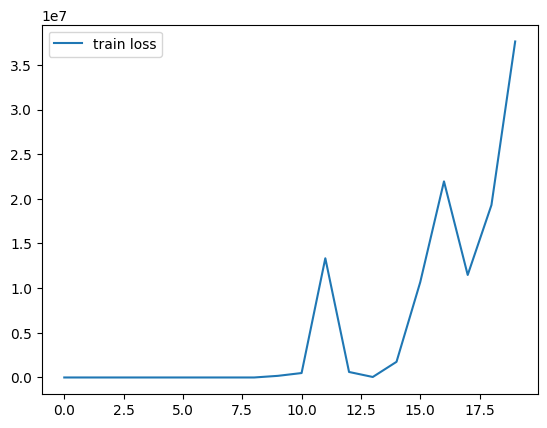

In [27]:
import matplotlib.pyplot as plt
plt.plot(losses_list_train, label="train loss")
plt.legend()
plt.show()

In [28]:
model = maskrcnn_resnet50_fpn(num_classes=7, trainable_backbone_layers=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
loss_fn = MulticlassDiceLoss(num_classes=7, softmax_dim=1)
epoches = 60
mask_path = 'C:/Users/Mihail/Desktop/Учёба/ML/data/dice/dice_photoset_2/masks/'
image_path = 'C:/Users/Mihail/Desktop/Учёба/ML/data/dice/dice_photoset_2/changed/'
losses_list_train = []
model.train()
for epoch in range(epoches):
    running_loss = 0.
    for i in X_train_filenames.index:
        masks = []
        # PIL.Image.open(path + 'changed/' + X_train_filenames.loc[i, 'filename']).show()
        for id in range(len(y_labels_train[i])):
            masks.append(torch.tensor(np.array(PIL.Image.open(mask_path + X_train_filenames.loc[i, 'filename'].split('.')[0] + '_mask' + str(id) + '.jpg').convert('1'), dtype=int), dtype=torch.uint8).to(device))
            # PIL.Image.open(mask_path + X_train_filenames.loc[i, 'filename'].split('.')[0] + '_mask' + str(id) + '.jpg').show()
            # print(y_labels_train[i][id])
        masks = torch.stack(masks[:], 0)
        image = torch.tensor(np.array(PIL.Image.open(image_path + X_train_filenames.loc[i, 'filename'])), dtype=torch.float).uniform_(0, 1).permute(2, 0, 1).to(device)
        optimizer.zero_grad()
        loss_dict  = model(torch.unsqueeze(image, 0), [{
            "boxes" : y_boxes_train[i].to(device),
            "labels" : y_labels_train[i].to(device),
            "masks" : masks,
            }])
        loss = sum(loss for loss in loss_dict.values()) #loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch {}    running loss {}".format(epoch+1, np.round(running_loss, 4)))
    losses_list_train.append(running_loss)
    torch.save(model.state_dict(), 'model_epoches/models/3/'+'__'+str(epoch+1)+".torch")

Epoch 1    running loss 128.6497
Epoch 2    running loss 98.0594
Epoch 3    running loss 99.9537
Epoch 4    running loss 97.7576
Epoch 5    running loss 97.22
Epoch 6    running loss 98.3197
Epoch 7    running loss 98.9182
Epoch 8    running loss 98.2244
Epoch 9    running loss 96.9639
Epoch 10    running loss 98.0147
Epoch 11    running loss 96.5642
Epoch 12    running loss 97.0026
Epoch 13    running loss 96.2036
Epoch 14    running loss 96.8268
Epoch 15    running loss 97.7201
Epoch 16    running loss 95.315
Epoch 17    running loss 99.5444
Epoch 18    running loss 97.9445
Epoch 19    running loss 99.5691
Epoch 20    running loss 97.5191
Epoch 21    running loss 99.0762
Epoch 22    running loss 98.5815
Epoch 23    running loss 99.9059
Epoch 24    running loss 98.9772
Epoch 25    running loss 99.9084
Epoch 26    running loss 100.2223
Epoch 27    running loss 99.5034
Epoch 28    running loss 99.2878
Epoch 29    running loss 99.1257
Epoch 30    running loss 99.3143
Epoch 31    running 

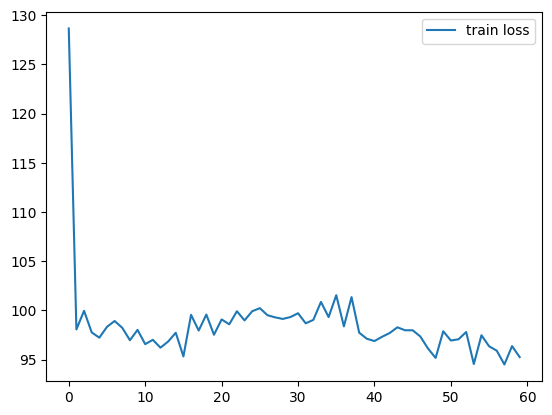

In [29]:
import matplotlib.pyplot as plt
plt.plot(losses_list_train, label="train loss")
plt.legend()
plt.show()

In [6]:
model = maskrcnn_resnet50_fpn(num_classes=7, trainable_backbone_layers=5).to(device)
model.load_state_dict(torch.load('model_epoches/models/3/__60.torch'))

<All keys matched successfully>

In [26]:
import cv2
import PIL.Image
import random
model.eval()
for i in X_test_filenames.index:
    image = PIL.Image.open(str(image_path + X_test_filenames.loc[i, 'filename']))
    image_tensor = torch.tensor(np.array(image), dtype=torch.float ).uniform_(0, 1).permute(2, 0, 1).to(device)
    pred = model(torch.unsqueeze(image_tensor, 0))
    print('ground-truth num of instances:', len(y_labels_test[i]), y_labels_test[i])
    print(pred[0].keys())
    image.show()
    if len(pred[0]['masks']):
        print('predicted num of instances:', len(pred[0]['masks']))
        sr = pd.Series(list(map(lambda x: (x[2] - x[0])*(x[3] - x[1]), pred[0]['boxes'].detach().cpu().numpy())))
        print(sr.min(), sr.mean(), sr.max(), image_tensor.shape[1] * image_tensor.shape[2])
        im = torch.tensor(np.array(image)).detach().cpu().numpy().astype(np.uint8)
        print(im.shape)
        df = pd.DataFrame(pred[0]['masks'][0][0].detach().cpu().numpy())
        print(sum(df == 1))
        im2 = im.copy()
        for i in range(len(pred[0]['masks'])):
            msk=pred[0]['masks'][i,0].detach().cpu().numpy()
            scr=pred[0]['scores'][i].detach().cpu().numpy()
            if scr != None and scr>0.8 :
                im2[:,:,0][msk>0.05] = random.randint(0,255)
                im2[:, :, 1][msk > 0.05] = random.randint(0,255)
                im2[:, :, 2][msk > 0.05] = random.randint(0, 255)
        cv2.imshow(str(scr), np.hstack([im,im2]))
        cv2.waitKey()

ground-truth num of instances: 2 tensor([2, 6])
dict_keys(['boxes', 'labels', 'scores', 'masks'])
predicted num of instances: 28
907.52264 4753.415 11794.319 1818048
(1114, 1632, 3)
1330896


KeyboardInterrupt: 

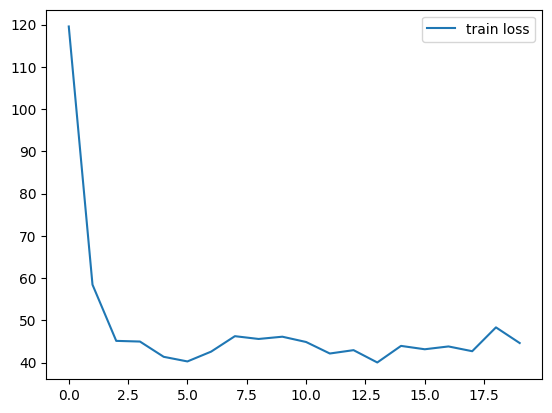

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses_list_train, label="train loss")
plt.legend()
plt.show()

In [348]:
model.load_state_dict(torch.load('model_epoches/13.torch'))

<All keys matched successfully>

In [49]:
import cv2
import random
model.eval()
for x in X_test_filenames.values:
    image = torch.tensor(np.array(PIL.Image.open(image_path + x[0])), dtype=torch.float ).uniform_(0, 1).permute(2, 0, 1)
    print(image_path + x, torch.unsqueeze(image, 0).shape)
    pred = model(torch.unsqueeze(image, 0))
    im = image.swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)
    im2 = im.copy()
    print(len(pred), len(pred[0]), pred)
    if len(pred[0]['masks']):
        for i in range(len(pred[0]['masks'])):
            msk=pred[0]['masks'][i,0].detach().cpu().numpy()
            scr=pred[0]['scores'][i].detach().cpu().numpy()
            if scr != None and scr>0.8 :
                im2[:,:,0][msk>0.5] = random.randint(0,255)
                im2[:, :, 1][msk > 0.5] = random.randint(0,255)
                im2[:, :, 2][msk > 0.5] = random.randint(0, 255)
        cv2.imshow(str(scr), np.hstack([im,im2]))
        cv2.waitKey()

['C:/Users/Mihail/Desktop/Учёба/ML/data/dice/dice_photoset_2/changed/P_20240928_215338_changed2.jpg'] torch.Size([1, 3, 1114, 1632])
1 4 [{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>), 'masks': tensor([], size=(0, 1, 1114, 1632))}]
['C:/Users/Mihail/Desktop/Учёба/ML/data/dice/dice_photoset_2/changed/P_20240928_215338_changed1.jpg'] torch.Size([1, 3, 1114, 1632])
1 4 [{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>), 'masks': tensor([], size=(0, 1, 1114, 1632))}]
['C:/Users/Mihail/Desktop/Учёба/ML/data/dice/dice_photoset_2/changed/P_20240928_215352_changed1.jpg'] torch.Size([1, 3, 1522, 1224])
1 4 [{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>), 'masks': tensor([], size=(0, 1, 1522, 1224

KeyboardInterrupt: 

In [36]:
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]

In [37]:
predictions = model(x)

In [38]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>),
  'masks': tensor([], size=(0, 1, 300, 400))},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>),
  'masks': tensor([], size=(0, 1, 500, 400))}]

In [39]:
model.train()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
x = [torch.rand(3, 410, 410), torch.rand(3, 410, 410)]

In [ ]:
#try simple like tensor 5x5 and mask 2x2 etc

In [77]:
x = [torch.rand(3, 7, 7), torch.rand(3, 7, 7)]
targets = [
    {'boxes': torch.tensor([[2, 5, 4, 7], [5, 7, 1, 3]]), 'labels': torch.tensor([1, 2]), 'masks': torch.tensor([[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0, 0], [0, 1, 1, 1, 1, 0, 0], [0, 1, 1, 1, 1, 0, 0], [0, 1, 1, 1, 1, 0, 0]], [[0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]])},
    {'boxes': torch.tensor([[2, 6, 2, 6]]), 'labels': torch.tensor([2]), 'masks': torch.tensor([[[0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0]]])},
]
targets = [
    {'boxes': torch.tensor([[2, 5, 4, 7], [5, 7, 1, 3]]), 'labels': torch.tensor([1, 2]), 'masks': torch.tensor([[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]])},
    {'boxes': torch.tensor([[2, 6, 2, 6]]), 'labels': torch.tensor([2]), 'masks': torch.tensor([[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0], [0, 0, 1, 1, 1, 0, 0], [0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]])},
]

In [78]:
predictions = model(x, targets)

AssertionError: All bounding boxes should have positive height and width. Found invalid box [571.4285888671875, 800.0, 114.28571319580078, 342.8571472167969] for target at index 0.

In [2]:
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os

batchSize=2
imageSize=[600,600]
device = torch.device('cuda:0') if  torch.cuda.is_available() else torch.device('cpu')

In [14]:
trainDir="../data/test"

imgs=[]
for pth in os.listdir(trainDir+"/few_data_train_masks"):
    imgs.append(trainDir+"/few_data_train_masks/"+pth)
imgs = imgs[1:] # CHECK!
imgs

['../data/test/few_data_train_masks/000ac425-289e-4ab8-af15-7228b485824e.jpg',
 '../data/test/few_data_train_masks/000bd8f2-0a69-421b-925e-c8aa695907b6.jpg',
 '../data/test/few_data_train_masks/000c52d2-6c0b-4005-b826-fcda8e7a37b9.jpg',
 '../data/test/few_data_train_masks/000fb981-32f0-420e-8819-60eac7586ac3.jpg',
 '../data/test/few_data_train_masks/00a0dddc-8b57-451f-853d-741f0161cb8c.jpg',
 '../data/test/few_data_train_masks/00a71784-153b-41ad-a6aa-bcd6b176cf50.jpg',
 '../data/test/few_data_train_masks/00aa065b-1cff-4055-a937-ee95a8c0f4b9.jpg',
 '../data/test/few_data_train_masks/00b61049-369f-4c28-a2b7-6e34820f792e.jpg',
 '../data/test/few_data_train_masks/00b67891-0b85-475d-8eb6-8ea550165129.jpg',
 '../data/test/few_data_train_masks/00bdfdd3-4ea8-4ff8-9427-0e711daeb6a1.jpg',
 '../data/test/few_data_train_masks/00c3572b-b691-46a7-b7d4-889426d54013.jpg',
 '../data/test/few_data_train_masks/00c87801-9747-4f8f-a907-53968c441638.jpg',
 '../data/test/few_data_train_masks/00c9aa1e-9982-42

In [19]:
import zipfile
zip = zipfile.ZipFile(trainDir + "/few_data_train_masks.zip")
zip.extractall(path="../data/test/")
zip.close()

In [3]:
def loadData():
  batch_Imgs=[]
  batch_Data=[]
  for i in range(batchSize):
        idx=random.randint(0,len(imgs)-1)
        img = cv2.imread(os.path.join(imgs[idx], os.listdir(imgs[idx])[0]))
        img = cv2.resize(img, imageSize, cv2.INTER_LINEAR)
        maskDir=os.path.join(imgs[idx], "masks")
        masks=[]
        for mskName in os.listdir(maskDir):
            vesMask = cv2.imread(maskDir+'/'+mskName, 0)
            vesMask = (vesMask > 0).astype(np.uint8) 
            vesMask=cv2.resize(vesMask,imageSize,cv2.INTER_NEAREST)
            masks.append(vesMask)
        num_objs = len(masks)
        if num_objs==0: return loadData()
        boxes = torch.zeros([num_objs,4], dtype=torch.float32)
        for i in range(num_objs):
            x,y,w,h = cv2.boundingRect(masks[i])
            boxes[i] = torch.tensor([x, y, x+w, y+h])
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        img = torch.as_tensor(img, dtype=torch.float32)
        data = {}
        data["boxes"] =  boxes
        data["labels"] =  torch.ones((num_objs,), dtype=torch.int64)   
        data["masks"] = masks
        batch_Imgs.append(img)
        batch_Data.append(data)  
  
  batch_Imgs=torch.stack([torch.as_tensor(d) for d in batch_Imgs],0)
  batch_Imgs = batch_Imgs.swapaxes(1, 3).swapaxes(2, 3)
  return batch_Imgs, batch_Data

In [8]:
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)

model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)

C:\Users\Михаил\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Михаил\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#15 54
model.train()
for i in range(10001):
   images, targets = loadData()
   images = list(image.to(device) for image in images)
   targets=[{k: v.to(device) for k,v in t.items()} for t in targets]
   
   optimizer.zero_grad()
   loss_dict = model(images, targets)
   print(loss_dict)
   losses = sum(loss for loss in loss_dict.values())
   
   losses.backward()
   optimizer.step()
   
   print(i,'loss:', losses.item())
   if i%200==0:
           torch.save(model.state_dict(), str(i)+".torch")
           print("Save model to:",str(i)+".torch")

In [17]:
torch.save(model.state_dict(), "../models/dice_RCNN_GPUtrained_4650epochs.pt")

In [1]:
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os

batchSize=2
imageSize=[600,600]
device = torch.device('cuda:0') if  torch.cuda.is_available() else torch.device('cpu')

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)
model.load_state_dict(torch.load("../models/dice_RCNN_GPUtrained_4650epochs.pt"))
model.to(device)# move model to the right devic
model.eval()

C:\Users\Михаил\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Михаил\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [3]:
imgPath = "../data/test/few_data_train_masks/0a16a7b9-ced5-4a05-b97d-9e9f66619fab.jpg/0a16a7b9-ced5-4a05-b97d-9e9f66619fab.jpg"
images = cv2.imread(imgPath)
images = cv2.resize(images, imageSize, cv2.INTER_LINEAR)
images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
images=images.swapaxes(1, 3).swapaxes(2, 3)
images = list(image.to(device) for image in images)

In [4]:
with torch.no_grad():
    pred = model(images)


In [5]:
pred[0]['masks'][3][0].cpu().numpy().astype('int')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
im= images[0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)
im2 = im.copy()
for i in range(len(pred[0]['masks'])):
    msk=pred[0]['masks'][i,0].detach().cpu().numpy()
    scr=pred[0]['scores'][i].detach().cpu().numpy()
    if scr>0.8 :
        im2[:,:,0][msk>0.5] += 100
        im2[:, :, 1][msk > 0.5] += 100
        im2[:, :, 2][msk > 0.5] += 100
cv2.imshow(str(scr), np.hstack([im,im2]))
cv2.waitKey()

-1

In [73]:
for i,x in enumerate(pred[0]['masks'][0][0]):
    for j,y in enumerate(x):
        if y != 0:

torch.Size([1, 600, 600])

In [ ]:
mask2 = pred[0]['masks'][0].copy()
for i in pred[0]['masks'][0]:
    pred[0]['masks'][0]

In [101]:
next(tuple([i,j]) for i,y in enumerate(pred[0]['masks'][0][0]) for j,x in enumerate(y) if x > 0)

(36, 73)

In [83]:
pred[0]['masks'][0][0] != 0

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')

In [ ]:
im= images[0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)
im2 = im.copy()
for i in range(len(pred[0]['masks'])):
    msk=pred[0]['masks'][i,0].detach().cpu().numpy()
    scr=pred[0]['scores'][i].detach().cpu().numpy()
    if scr>0.8 :
        im2[:,:,0][msk>0.5] = random.randint(0,255)
        im2[:, :, 1][msk > 0.5] = random.randint(0,255)
        im2[:, :, 2][msk > 0.5] = random.randint(0, 255)
cv2.imshow(str(scr), np.hstack([im,im2]))
cv2.waitKey()

In [62]:
print(cv2.imwrite("C:\\a.png", images[0].cpu().numpy()))
print(cv2.imwrite("../data/test/few_data_train_masks/0a16a7b9-ced5-4a05-b97d-9e9f66619fab.jpg/mask.png", pred[0]['masks'][3].cpu().numpy()))
print (cv2.imwrite(str(pth / "mask.png"), pred[0]['masks'][3].cpu().numpy()))
cv2.imwrite("mask.png", np.array([[1, 1], [111, 111]]))


False
False
False


True

In [54]:
from pathlib import Path
pth = Path(os.getcwd()).resolve(strict=True).parent / "data" / "test" / "few_data_train_masks" / "0a16a7b9-ced5-4a05-b97d-9e9f66619fab.jpg"
pth

WindowsPath('C:/Users/Михаил/data/test/few_data_train_masks/0a16a7b9-ced5-4a05-b97d-9e9f66619fab.jpg')